In [1]:
from newsapi import NewsApiClient
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

newsapi = NewsApiClient(api_key='e6ab46ae97e04bf0b1180daf707c8b8c')

# top_headlines = newsapi.get_top_headlines(q='bitcoin', language='en')

data = []
for page in range(1, 8):
    
    # Request page of articles
    news = newsapi.get_everything(q='+bitcoin', sort_by='popularity',
                                  page_size=100, page=page, from_param='2018-01-01')

    articles = news["articles"]
    for article in articles:
        link = article["url"]
        date = article['publishedAt'][:10]
        r = requests.get(link)
        bs = BeautifulSoup(r.text, 'html.parser')
        if bs.find('title') == None:
            continue
        article_title = bs.find('title').text

        # Loop to make sure bitcoin is mentioned in the article
        article_words = ""
        for paragraph in bs.find_all('p'):
            
            # Skip advertisements
            if paragraph.text == 'Advertisement':
                continue
            article_words += paragraph.text
        
        # Skip this article if it doesn't mention bitcoin
        if 'bitcoin' not in article_words or 'Bitcoin' not in article_words:
            continue
        data.append([date, link, article_title])
    
news_articles = pd.DataFrame(data, columns=['Date', 'Url', 'Title'])

In [15]:
print("Size:", news_articles.shape)
news_articles.head()

Size: (190, 3)


,Date,Url,Title
0,2018-02-05,https://www.engadget.com/2018/02/05/lloyds-ban...,UK banks ban Bitcoin purchases with credit cards
1,2018-01-28,https://www.engadget.com/2018/01/27/coincheck-...,Coincheck loses $400 million in massive crypto...
2,2018-03-04,https://www.engadget.com/2018/03/04/after-math...,After Math: Internet flame war
3,2018-04-05,https://www.wired.com/story/bitcoin-blockchain...,A 200-Year-Old Idea Offers a New Way to Trace ...
4,2018-03-22,https://www.wired.com/story/where-could-bitcoi...,Where Could Bitcoin Succeed as a Currency? In ...


In [3]:
import json
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, SentimentOptions

nlp = NaturalLanguageUnderstandingV1(username='7ef284ae-4f83-42b6-8d56-6c21723f1d8d',
                                     password='c7jBn0yAVHp2',
                                     version='2018-03-16')

data = []

for index, row in news_articles.iterrows():
    date = row['Date']
    link = row['Url']
    title = row['Title']
    
    response = nlp.analyze(url= link,
                       features=Features(sentiment=SentimentOptions(targets=['bitcoin'])))
    
    r = json.dumps(response, indent=2)
    r_json = json.loads(r)
    sentiment = r_json['sentiment']['targets'][0]['score']
    doc_sentiment = r_json['sentiment']['document']['score']
    
    row = [date, title, sentiment, doc_sentiment]
    data.append(row)
    
articles_sentiment = pd.DataFrame(data, columns=['Date', 'Title', 'Bitcoin Sentiment', 'Document Sentiment'])

In [16]:
print("Size:", articles_sentiment.shape)
articles_sentiment.head()

Size: (190, 4)


,Date,Title,Bitcoin Sentiment,Document Sentiment
0,2018-02-05,UK banks ban Bitcoin purchases with credit cards,-0.544509,-0.255693
1,2018-01-28,Coincheck loses $400 million in massive crypto...,-0.499032,-0.587959
2,2018-03-04,After Math: Internet flame war,-0.675488,-0.358912
3,2018-04-05,A 200-Year-Old Idea Offers a New Way to Trace ...,-0.372854,-0.241051
4,2018-03-22,Where Could Bitcoin Succeed as a Currency? In ...,-0.127302,-0.212710


In [17]:
# Group sentiment by date and average sentiment
articles_clean_sentiment = articles_sentiment.drop(labels='Title', axis=1)
articles_clean_sentiment = articles_clean_sentiment.groupby(pd.Grouper(key='Date', sort=True)).mean()
print("Shape:", articles_clean_sentiment.shape)
articles_clean_sentiment.head()

Shape: (67, 2)


,Bitcoin Sentiment,Document Sentiment
Date,,
2018-01-28,-0.391111,-0.227191
2018-01-29,-0.185718,-0.150089
2018-01-30,0.000000,-0.072474
2018-01-31,-0.172579,0.114903
2018-02-01,-0.300366,-0.245978


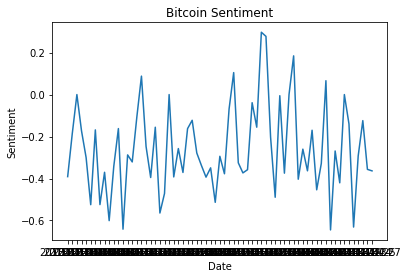

In [37]:
# Graph for just Bitcoin Sentiment
bitcoin_sentiment = articles_clean_sentiment['Bitcoin Sentiment']
plt.plot(bitcoin_sentiment)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Bitcoin Sentiment')
plt.show()

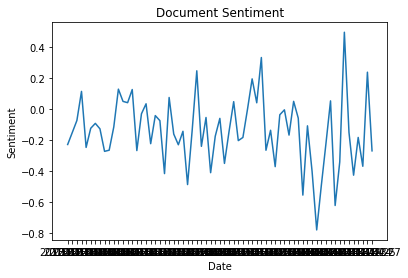

In [36]:
# Graph for just Document Sentiment
document_sentiment = articles_clean_sentiment['Document Sentiment']
plt.plot(document_sentiment)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Document Sentiment')
plt.show()

In [20]:
# Averaged sentiment between bitcoin and document
averaged_sentiment = articles_clean_sentiment.mean(axis=1)
averaged_sentiment.head()

Date
2018-01-28   -0.309150
2018-01-29   -0.167903
2018-01-30   -0.036237
2018-01-31   -0.028838
2018-02-01   -0.273172
dtype: float64

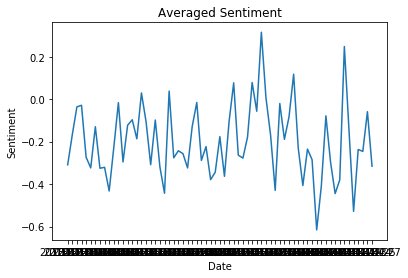

In [35]:
# Graph for averaged sentiment
plt.plot(averaged_sentiment)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Averaged Sentiment')
plt.show()

In [107]:
sum_sentiment = articles_clean_sentiment.sum(axis=1)
sum_sentiment.head()

Date
2018-01-28   -0.618301
2018-01-29   -0.335807
2018-01-30   -0.072474
2018-01-31   -0.057676
2018-02-01   -0.546344
dtype: float64

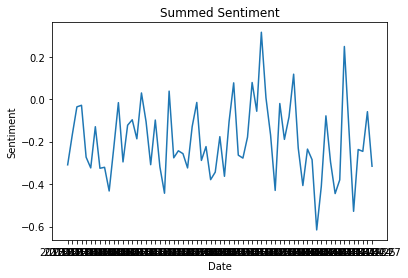

In [108]:
plt.plot(averaged_sentiment)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Summed Sentiment')
plt.show()

In [26]:
sentiment_change = []
for c, row in enumerate(averaged_sentiment):
    if c == 0:
        before = row
        continue
    sentiment_change.append(row - before)
    before = row

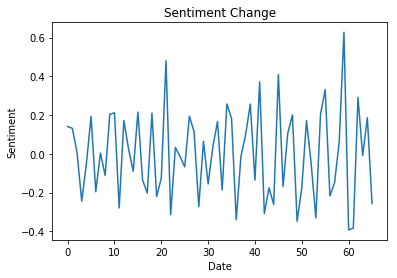

In [34]:
# Graph for sentiment change for next day
# Ex. (sentiment 2018-01-02) minus (sentiment 2018-01-01) = sentiment change
# Graph the trend of sentiment change
plt.plot(sentiment_change)
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment Change')
plt.show()

In [95]:
import datetime
import ipywidgets as widgets

days = 93
freq = 86400

def retrieve(days = days, freq = freq, pairs = ['USDT_BTC']):
    df_list = list()
    period = days and (datetime.datetime.now() - datetime.timedelta(days)).timestamp()
    print('\nCurrency pairs: ', ', '.join(pairs), '({} pairs)'.format(len(pairs)))
    f = widgets.FloatProgress(min=0, max=len(pairs))
    print('\nProgress: '), display(f)
    
    for p in pairs: 
        url = "https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end=9999999999&period={}".format(p, period, freq)
        f.value += 0.1
        temp = pd.read_json(url).set_index('date')
        data = dict()
        f.value += 0.4
        for k,v in temp.to_dict().items():
            data[(p, k)] = v
        df_list.append(pd.DataFrame(data))
        f.value += 0.5
    
    print("done!")
    return df_list


pairs = ['USDT_BTC']
data = retrieve(pairs=pairs)
data[0].head()


Currency pairs:  USDT_BTC (1 pairs)

Progress: 


A Jupyter Widget

done!


USDT_BTC                                            \
                   close          high           low          open   
2018-01-28  11849.999900  12200.000000  11425.000000  11480.561390   
2018-01-29  11227.000000  12000.000000  11100.000000  11849.999900   
2018-01-30  10181.539350  11271.328870   9850.000000  11235.465995   
2018-01-31  10261.256651  10424.626885   9700.463886  10184.664649   
2018-02-01   9199.570000  10367.784124   8820.000000  10261.256651   

                                                       
            quoteVolume        volume weightedAverage  
2018-01-28  4119.401875  4.887871e+07    11865.487990  
2018-01-29  3123.577900  3.576145e+07    11448.875600  
2018-01-30  6439.280513  6.737555e+07    10463.210306  
2018-01-31  4204.127842  4.231689e+07    10065.557265  
2018-02-01  6084.614804  5.749454e+07     9449.166234

In [96]:
bitcoin_price = pd.DataFrame(data[0]).iloc[:,0]
bitcoin_price.head()

2018-01-28    11849.999900
2018-01-29    11227.000000
2018-01-30    10181.539350
2018-01-31    10261.256651
2018-02-01     9199.570000
Name: (USDT_BTC, close), dtype: float64

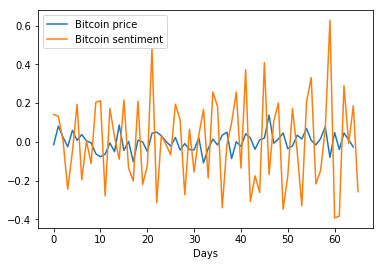

In [122]:
plt.plot((np.exp(np.diff(np.log(bitcoin_price))) -1)[27:], label='Bitcoin price')
plt.plot(sentiment_change, label='Bitcoin sentiment')
plt.plot()
plt.legend()
plt.xlabel('Days')
plt.show()